# Pengolahan Citra Digital Kelompok 5

Prerequisite Files:
- Unet Membrane https://www.kaggle.com/datasets/tasmiarahmanaanika/unet-lung-mask

In [4]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import math
import gridfs


from glob import glob
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import load_model
from pymongo import MongoClient

# Load Dataset Training dan Valid

In [5]:
client = MongoClient("mongodb://localhost:27017/")  
db = client["CheXpert-DB"]
collection_train = db["Metadata-Train"]

In [6]:
documents = list(collection_train.find({}))

# Extract image paths 
objects = [doc["Path"] for doc in documents]

# Display count
print("Number of Observations:", len(objects))

Number of Observations: 223414


In [7]:
# Number of rows to sample
n_rows = 10000

# Read and sample randomly
train_df = pd.DataFrame(documents)
train_df.drop(columns=['_id'], inplace=True, errors='ignore')
train_df = train_df.sample(n=n_rows, random_state=42) 
train_df = train_df.reset_index(drop=True) 
train_df.head()

,Path,Sex,Age,Frontal_Lateral,AP_PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
0,D:/Downloads/train/patient00082/study1/view1_f...,Male,18,Frontal,PA,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,D:/Downloads/train/patient35759/study9/view1_f...,Male,90,Frontal,AP,0,0,1,0,0,1,0,0,1,0,0,0,0,1
2,D:/Downloads/train/patient04789/study1/view2_l...,Male,39,Lateral,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,D:/Downloads/train/patient38491/study5/view1_f...,Male,60,Frontal,AP,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,D:/Downloads/train/patient06537/study3/view1_f...,Female,66,Frontal,AP,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [8]:
# Classes used based on CheXpert paper
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
policy = ['ones','zeroes','mixed']
x_path,labels = train_df["Path"].to_numpy(), train_df[class_names]

In [9]:
print(x_path[:5])

['D:/Downloads/train/patient00082/study1/view1_frontal.jpg'
 'D:/Downloads/train/patient35759/study9/view1_frontal.jpg'
 'D:/Downloads/train/patient04789/study1/view2_lateral.jpg'
 'D:/Downloads/train/patient38491/study5/view1_frontal.jpg'
 'D:/Downloads/train/patient06537/study3/view1_frontal.jpg']


In [10]:
# Get data
train_df = pd.DataFrame({'path':x_path})
df2 = pd.DataFrame(labels,columns=class_names)
train_df[list(df2.columns)]=df2.astype(int)
train_df.head()

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/train/patient00082/study1/view1_f...,0,0,0,0,0
1,D:/Downloads/train/patient35759/study9/view1_f...,1,1,0,1,0
2,D:/Downloads/train/patient04789/study1/view2_l...,0,0,0,0,1
3,D:/Downloads/train/patient38491/study5/view1_f...,0,0,0,1,0
4,D:/Downloads/train/patient06537/study3/view1_f...,1,0,0,0,0


Clean Labels Summary:
Pleural_Effusion    3830
Atelectasis         3019
Edema               2308
Cardiomegaly        1546
Consolidation        628
dtype: int64


(<Axes: xlabel='None', ylabel='0'>,
 ([0, 1, 2, 3, 4],
  [Text(0, 0, 'Pleural_Effusion'),
   Text(1, 0, 'Atelectasis'),
   Text(2, 0, 'Edema'),
   Text(3, 0, 'Cardiomegaly'),
   Text(4, 0, 'Consolidation')]))

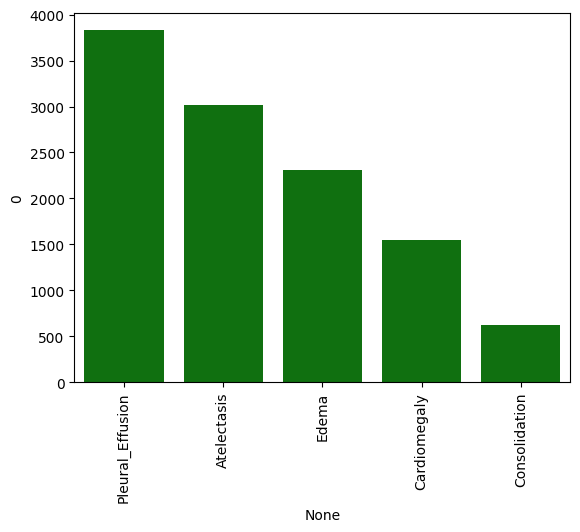

In [11]:
print("Clean Labels Summary:")
clean_labels = train_df[class_names].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [12]:
# Get Valid dataset
collection_valid = db["Metadata-Valid"]

documents_valid = list(collection_valid.find({}))

# Extract image paths (like Path_Metadata)
objects_valid = [doc["Path"] for doc in documents_valid]

# Display count
print("Number of Observations:", len(objects_valid))

Number of Observations: 234


In [13]:
# get valid dataset
valid_df = pd.DataFrame(documents_valid)
valid_df.drop(columns=['_id'], inplace=True, errors='ignore')
valid_df.head()

,Path,Sex,Age,Frontal_Lateral,AP_PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
0,D:/Downloads/valid/patient64541/study1/view1_f...,Male,73,Frontal,AP,0,1,1,1,0,0,0,0,0,0,0,0,0,0
1,D:/Downloads/valid/patient64542/study1/view1_f...,Male,70,Frontal,PA,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,D:/Downloads/valid/patient64542/study1/view2_l...,Male,70,Lateral,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,D:/Downloads/valid/patient64543/study1/view1_f...,Male,85,Frontal,AP,0,1,0,1,0,1,0,0,0,0,0,0,0,0
4,D:/Downloads/valid/patient64544/study1/view1_f...,Female,42,Frontal,AP,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
valid_x_path,valid_labels = valid_df["Path"].to_numpy(), valid_df[class_names]

In [15]:
valid_df = pd.DataFrame({'path':valid_x_path})
df2 = pd.DataFrame(labels,columns=class_names)
valid_df[list(df2.columns)]=df2.astype(int)
valid_df.head()

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/valid/patient64541/study1/view1_f...,0,0,0,0,0
1,D:/Downloads/valid/patient64542/study1/view1_f...,1,1,0,1,0
2,D:/Downloads/valid/patient64542/study1/view2_l...,0,0,0,0,1
3,D:/Downloads/valid/patient64543/study1/view1_f...,0,0,0,1,0
4,D:/Downloads/valid/patient64544/study1/view1_f...,1,0,0,0,0


Clean Labels Summary:
Pleural_Effusion    79
Atelectasis         67
Edema               55
Cardiomegaly        38
Consolidation       13
dtype: int64


(<Axes: xlabel='None', ylabel='0'>,
 ([0, 1, 2, 3, 4],
  [Text(0, 0, 'Pleural_Effusion'),
   Text(1, 0, 'Atelectasis'),
   Text(2, 0, 'Edema'),
   Text(3, 0, 'Cardiomegaly'),
   Text(4, 0, 'Consolidation')]))

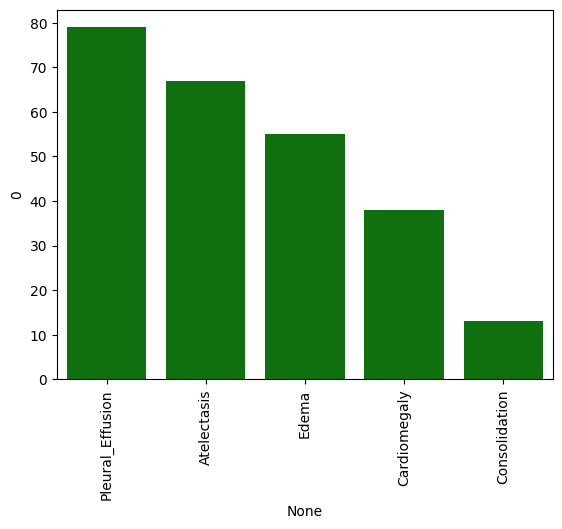

In [16]:
print("Clean Labels Summary:")
clean_labels_valid = valid_df[class_names].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels_valid) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels_valid.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [17]:
my_glob_valid = valid_df['path'].tolist()
print('Number of Observations: ', len(my_glob_valid)) 
print(my_glob_valid[:5])

Number of Observations:  234
['D:/Downloads/valid/patient64541/study1/view1_frontal.jpg', 'D:/Downloads/valid/patient64542/study1/view1_frontal.jpg', 'D:/Downloads/valid/patient64542/study1/view2_lateral.jpg', 'D:/Downloads/valid/patient64543/study1/view1_frontal.jpg', 'D:/Downloads/valid/patient64544/study1/view1_frontal.jpg']


In [18]:
my_glob_train = train_df['path'].tolist()
print('Number of Observations: ', len(my_glob_train)) 
print(my_glob_train[:5])

Number of Observations:  10000
['D:/Downloads/train/patient00082/study1/view1_frontal.jpg', 'D:/Downloads/train/patient35759/study9/view1_frontal.jpg', 'D:/Downloads/train/patient04789/study1/view2_lateral.jpg', 'D:/Downloads/train/patient38491/study5/view1_frontal.jpg', 'D:/Downloads/train/patient06537/study3/view1_frontal.jpg']


# Resize Gambar

In [19]:
# function to resize input image with padding
def resize_with_padding(img, target_size=224, pad_color=0):
    h, w = img.shape[:2]

    # Scale with ratio maintained
    if h > w:
        new_h = target_size
        new_w = int(w * (target_size / h))
    else:
        new_w = target_size
        new_h = int(h * (target_size / w))

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Calculate padding
    pad_vert = target_size - new_h
    pad_horz = target_size - new_w

    top = pad_vert // 2
    bottom = pad_vert - top
    left = pad_horz // 2
    right = pad_horz - left

    # Add padding
    padded = cv2.copyMakeBorder(
        resized,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=pad_color,
    )

    return padded


Pengaturan Direktori dan Resize Gambar

In [20]:
import cv2
from tqdm import tqdm

# resized directory 
resized_valid = "D:/Downloads/valid_resized"
resized_train = "D:/Downloads/train_resized"

TARGET_SIZE = 256
PAD_COLOR = 0 

In [21]:
def resize_images(my_glob, resized_output_dir):
    processed = 0
    failed = 0
    
    os.makedirs(resized_output_dir, exist_ok=True)
    
    glob = []
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(resized_output_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions:
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} resized images.")
        return glob
    else:
        print("No resized images found.")

        for img_path in tqdm(my_glob, desc="Resizing images"):
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print(f"Failed to read image: {img_path}")
                failed += 1
                continue

            resized_img = resize_with_padding(img, target_size=TARGET_SIZE, pad_color=PAD_COLOR)

            # Build relative path from the glob path
            parts = img_path.replace("\\", "/").split("/")
            rel = "/".join(parts[3:])  # keep everything after the top-level folder

            out_path = os.path.join(resized_output_dir, rel)
            os.makedirs(os.path.dirname(out_path), exist_ok=True)

            if resized_img.dtype != np.uint8:
                max_val = resized_img.max() or 1.0
                if max_val <= 1.0:
                    save_img = (resized_img * 255).astype(np.uint8)
                else:
                    save_img = resized_img.astype(np.uint8)
            else:
                save_img = resized_img

            success = cv2.imwrite(out_path, save_img)
            if not success:
                print(f"Failed to save: {out_path}")
                failed += 1
                continue
            
            processed += 1
            glob.append(out_path)
            
        print(f"Done. Processed: {processed}, Failed: {failed}")    
        return glob


In [22]:
glob_valid_resize = resize_images(my_glob_valid, resized_valid)

Found 234 resized images.


In [23]:
glob_train_resize = resize_images(my_glob_train, resized_train)

Found 10000 resized images.


In [24]:
print(glob_valid_resize[:5])

['D:/Downloads/valid_resized\\patient64541\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64542\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64542\\study1\\view2_lateral.jpg', 'D:/Downloads/valid_resized\\patient64543\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64544\\study1\\view1_frontal.jpg']


In [25]:
print(glob_train_resize[:5])

['D:/Downloads/train_resized\\patient00006\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00012\\study3\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00023\\study6\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00039\\study7\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00042\\study1\\view1_frontal.jpg']


In [26]:
def replace_path(dataframe, glob):
    mapping = {}
    for path, new_path in zip(dataframe['path'], glob):
        mapping[path.replace("\\", "/")] = new_path.replace("\\", "/")
        
    dataframe['path'] = dataframe['path'].map(mapping.get)
    return dataframe

In [27]:
valid_df = replace_path(valid_df, glob_valid_resize)
valid_df

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/valid_resized/patient64541/study1...,0,0,0,0,0
1,D:/Downloads/valid_resized/patient64542/study1...,1,1,0,1,0
2,D:/Downloads/valid_resized/patient64542/study1...,0,0,0,0,1
3,D:/Downloads/valid_resized/patient64543/study1...,0,0,0,1,0
4,D:/Downloads/valid_resized/patient64544/study1...,1,0,0,0,0
...,...,...,...,...,...,...
229,D:/Downloads/valid_resized/patient64736/study1...,1,0,0,0,1
230,D:/Downloads/valid_resized/patient64737/study1...,1,0,0,0,0
231,D:/Downloads/valid_resized/patient64738/study1...,0,0,0,0,0
232,D:/Downloads/valid_resized/patient64739/study1...,0,0,0,0,0


In [28]:
train_df = replace_path(train_df, glob_train_resize)
train_df

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/train_resized/patient00006/study1...,0,0,0,0,0
1,D:/Downloads/train_resized/patient00012/study3...,1,1,0,1,0
2,D:/Downloads/train_resized/patient00023/study6...,0,0,0,0,1
3,D:/Downloads/train_resized/patient00039/study7...,0,0,0,1,0
4,D:/Downloads/train_resized/patient00042/study1...,1,0,0,0,0
...,...,...,...,...,...,...
9995,D:/Downloads/train_resized/patient64491/study2...,1,0,1,0,0
9996,D:/Downloads/train_resized/patient64498/study1...,0,0,0,0,0
9997,D:/Downloads/train_resized/patient64501/study1...,1,0,0,0,1
9998,D:/Downloads/train_resized/patient64506/study1...,0,0,0,0,1


# Membuat Mask untuk Gambar

Load model Unet Membrane

In [29]:
mask_model = load_model("unet_membrane_a6.hdf5")
mask_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
print(mask_model.input_shape)

(None, 256, 256, 1)


In [31]:
mask_output_valid = "D:/Downloads/masks/valid"
mask_output_train = "D:/Downloads/masks/train"

In [32]:
def preprocess_image(file_path, target_size=(256, 256)):
    img = cv2.imread(file_path)
    if img is None:
        print(f"Error: Unable to read image at {file_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = cv2.GaussianBlur(img, (5,5), 0)  # reduce noise
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)   # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [33]:
def predict_mask(model, image, verbose=0): 
    pred = model.predict(image, verbose=verbose) * 255
    return pred

In [34]:
def predict_mask_image(path_glob, output_directory):
    glob = []
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(output_directory):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_mask"):
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} masks.")
        return glob
    else:
        print("No mask found.")
        for image_path in tqdm(path_glob, desc="Generating masks", unit="img" ):
            test_im = preprocess_image(image_path)
            if test_im is None:
                tqdm.write(f"Failed to preprocess: {image_path}")
                continue

            try:
                mask = predict_mask(mask_model, test_im, verbose=0)
                
                parts = image_path.replace("\\", "/").split("/")
                relative_path = "/".join(parts[3:])  # keep everything after the top-level folder
                mask_path = os.path.join(output_directory, relative_path)
                os.makedirs(os.path.dirname(mask_path), exist_ok=True)
                
                directory, filename = os.path.split(mask_path)
                name, ext = os.path.splitext(filename)
                new_filename = f"{name}_mask{ext}"
                mask_path = os.path.join(directory, new_filename)

                os.makedirs(directory, exist_ok=True)

                mask_to_save = mask[0, :, :, 0]

                se_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                se_5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
                dst_dilate_inv = cv2.dilate(mask_to_save, se_3, iterations = 1)
                dst_erosi_inv = cv2.erode(dst_dilate_inv, se_3, iterations = 2)
                dst_dilate2_inv = cv2.dilate(dst_erosi_inv, se_5, iterations = 2)
                dst_erosi2_inv = cv2.erode(dst_dilate2_inv, se_5, iterations = 3)
                dst_dilate3_inv = cv2.dilate(dst_erosi2_inv, se_3, iterations = 1)
                mask_to_save = dst_dilate3_inv

                if mask_to_save.dtype != np.uint8:
                    if mask_to_save.max() <= 1.0:
                        mask_to_save = (mask_to_save * 255).astype(np.uint8)
                    else:
                        mask_to_save = mask_to_save.astype(np.uint8)

                if cv2.imwrite(mask_path, mask_to_save):
                    glob.append(mask_path)
                else:
                    tqdm.write(f"Failed to save: {mask_path}")

            except Exception as e:
                tqdm.write(f"Error processing {image_path}: {e}")

        return glob


Membuat mask untuk dataset training dan validasi

In [35]:
mask_glob_train = predict_mask_image(glob_train_resize, mask_output_train)

Found 10000 masks.


In [36]:
mask_glob_valid = predict_mask_image(glob_valid_resize, mask_output_valid)

Found 234 masks.


# Menggabungkan Mask dengan Gambar Asli

In [37]:
def convolutionize_mask(mask_glob, resize_glob, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    glob = []
    
    for mask_path, image_path in zip(mask_glob, resize_glob):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None or image is None:
            print(f"Failed to read mask or image: {mask_path}, {image_path}")
            continue
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Convert mask to weights 0–1
        mask_float = mask.astype("float32") / 255.0

        # Convolve the image with a Gaussian kernel
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Convolution-style combination
        result = image * mask_float + blurred * (1 - mask_float)
        result = np.clip(result, 0, 255).astype("uint8")
        
        # Build output path
        parts = image_path.replace("\\", "/").split("/")
        relative_path = "/".join(parts[3:])
        output_path = os.path.join(output_directory, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        directory, filename = os.path.split(output_path)
        name, ext = os.path.splitext(filename)
        new_filename = f"{name}_conv{ext}"
        output_path = os.path.join(directory, new_filename)
        
        # Save result
        success = cv2.imwrite(output_path, result)
        if success:
            print(f"✓ Saved: {output_path}")
            glob.append(output_path)
        else:
            print(f"✗ Failed to save: {output_path}")
    
    return glob


In [38]:
def check_convolutionized_images(mask_glob, img_glob, root_dir):
    valid_extensions = {".jpg", ".jpeg", ".png"}
    found = []
    os.makedirs(root_dir, exist_ok=True)

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_conv"):
                found.append(os.path.join(root, file))
    
    if found:
        print(f"Found {len(found)} convolutionized images.")
        return found
    else:
        print("No convolutionized images found. Proceed to generate convolutionized images.")
        return convolutionize_mask(mask_glob, img_glob, root_dir)

In [39]:
conv_output_valid = "D:/Downloads/conv_valid"
conv_glob_valid = check_convolutionized_images(mask_glob_valid, glob_valid_resize, conv_output_valid)

Found 234 convolutionized images.


In [40]:
conv_output_train = "D:/Downloads/conv_train"
conv_glob_train = check_convolutionized_images(mask_glob_train, glob_train_resize, conv_output_train)

Found 10000 convolutionized images.


In [41]:
valid_df_mask = valid_df 
valid_df_mask = replace_path(valid_df_mask, conv_glob_valid)
valid_df_mask

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/conv_valid/patient64541/study1/vi...,0,0,0,0,0
1,D:/Downloads/conv_valid/patient64542/study1/vi...,1,1,0,1,0
2,D:/Downloads/conv_valid/patient64542/study1/vi...,0,0,0,0,1
3,D:/Downloads/conv_valid/patient64543/study1/vi...,0,0,0,1,0
4,D:/Downloads/conv_valid/patient64544/study1/vi...,1,0,0,0,0
...,...,...,...,...,...,...
229,D:/Downloads/conv_valid/patient64736/study1/vi...,1,0,0,0,1
230,D:/Downloads/conv_valid/patient64737/study1/vi...,1,0,0,0,0
231,D:/Downloads/conv_valid/patient64738/study1/vi...,0,0,0,0,0
232,D:/Downloads/conv_valid/patient64739/study1/vi...,0,0,0,0,0


In [42]:
train_df_mask = train_df
train_df_mask = replace_path(train_df_mask, conv_glob_train)
train_df_mask.head()

,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Pleural_Effusion
0,D:/Downloads/conv_train/patient00006/study1/vi...,0,0,0,0,0
1,D:/Downloads/conv_train/patient00012/study3/vi...,1,1,0,1,0
2,D:/Downloads/conv_train/patient00023/study6/vi...,0,0,0,0,1
3,D:/Downloads/conv_train/patient00039/study7/vi...,0,0,0,1,0
4,D:/Downloads/conv_train/patient00042/study1/vi...,1,0,0,0,0


In [43]:
IMG_SIZE = (256,256)
CHANNELS = 3

In [44]:
base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           rotation_range=10,
                                                           width_shift_range=0.05,
                                                           height_shift_range=0.05,
                                                           zoom_range=0.1,
                                                           horizontal_flip=True)

base_gen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = base_gen.flow_from_dataframe(dataframe=train_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle=True,
                                         batch_size=16)

valid_gen = base_gen_valid.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle = True,
                                         batch_size=16)  

train_gen_mask = base_gen.flow_from_dataframe(dataframe=train_df_mask,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle=True,
                                         batch_size=16)

valid_gen_mask = base_gen_valid.flow_from_dataframe(dataframe=valid_df_mask,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle = True,
                                         batch_size=16)  

Found 10000 validated image filenames.
Found 234 validated image filenames.
Found 10000 validated image filenames.
Found 234 validated image filenames.


# DenseNet Model 

In [45]:
model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze sebagian besar layer
for layer in model.layers[:-30]:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_names), activation='sigmoid')(x)

model = tf.keras.Model(inputs=model.input, outputs=output)
model_mask = tf.keras.Model(inputs=model.input, outputs=output)

In [46]:
loss_fn = BinaryCrossentropy(from_logits=False)

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name="auc")
    ]
)

model_mask.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name="auc")
    ]
)

In [48]:
cb = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
]

In [ ]:
history_nomask = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=3,
    callbacks=cb
)
model.save("densenet121_nomask.keras")

c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


474/625 ━━━━━━━━━━━━━━━━━━━━ 1:42 682ms/step - auc: 0.4887 - loss: 0.5616

KeyboardInterrupt: 

In [ ]:
history_mask = model_mask.fit(
    train_gen_mask,
    validation_data=valid_gen_mask,
    epochs=3,
    callbacks=cb
)
model_mask.save("densenet121_mask.keras")

In [ ]:
def compare_learning_curves(history1, history2, labels=("Model 1", "Model 2")):
    # Ekstrak dictionary metric
    hist1 = history1.history
    hist2 = history2.history

    epochs1 = range(1, len(hist1['loss']) + 1)
    epochs2 = range(1, len(hist2['loss']) + 1)

    import matplotlib.pyplot as plt
    import matplotlib.style as style
    style.use("bmh")

    plt.figure(figsize=(12, 10))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs1, hist1['loss'], label=f'{labels[0]} Training Loss')
    plt.plot(epochs2, hist2['loss'], label=f'{labels[1]} Training Loss')

    if 'val_loss' in hist1:
        plt.plot(epochs1, hist1['val_loss'], label=f'{labels[0]} Validation Loss')
    if 'val_loss' in hist2:
        plt.plot(epochs2, hist2['val_loss'], label=f'{labels[1]} Validation Loss')

    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot AUC
    plt.subplot(2, 1, 2)
    if 'auc' in hist1:
        plt.plot(epochs1, hist1['auc'], label=f'{labels[0]} Training AUC')
    if 'auc' in hist2:
        plt.plot(epochs2, hist2['auc'], label=f'{labels[1]} Training AUC')

    if 'val_auc' in hist1:
        plt.plot(epochs1, hist1['val_auc'], label=f'{labels[0]} Validation AUC')
    if 'val_auc' in hist2:
        plt.plot(epochs2, hist2['val_auc'], label=f'{labels[1]} Validation AUC')

    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


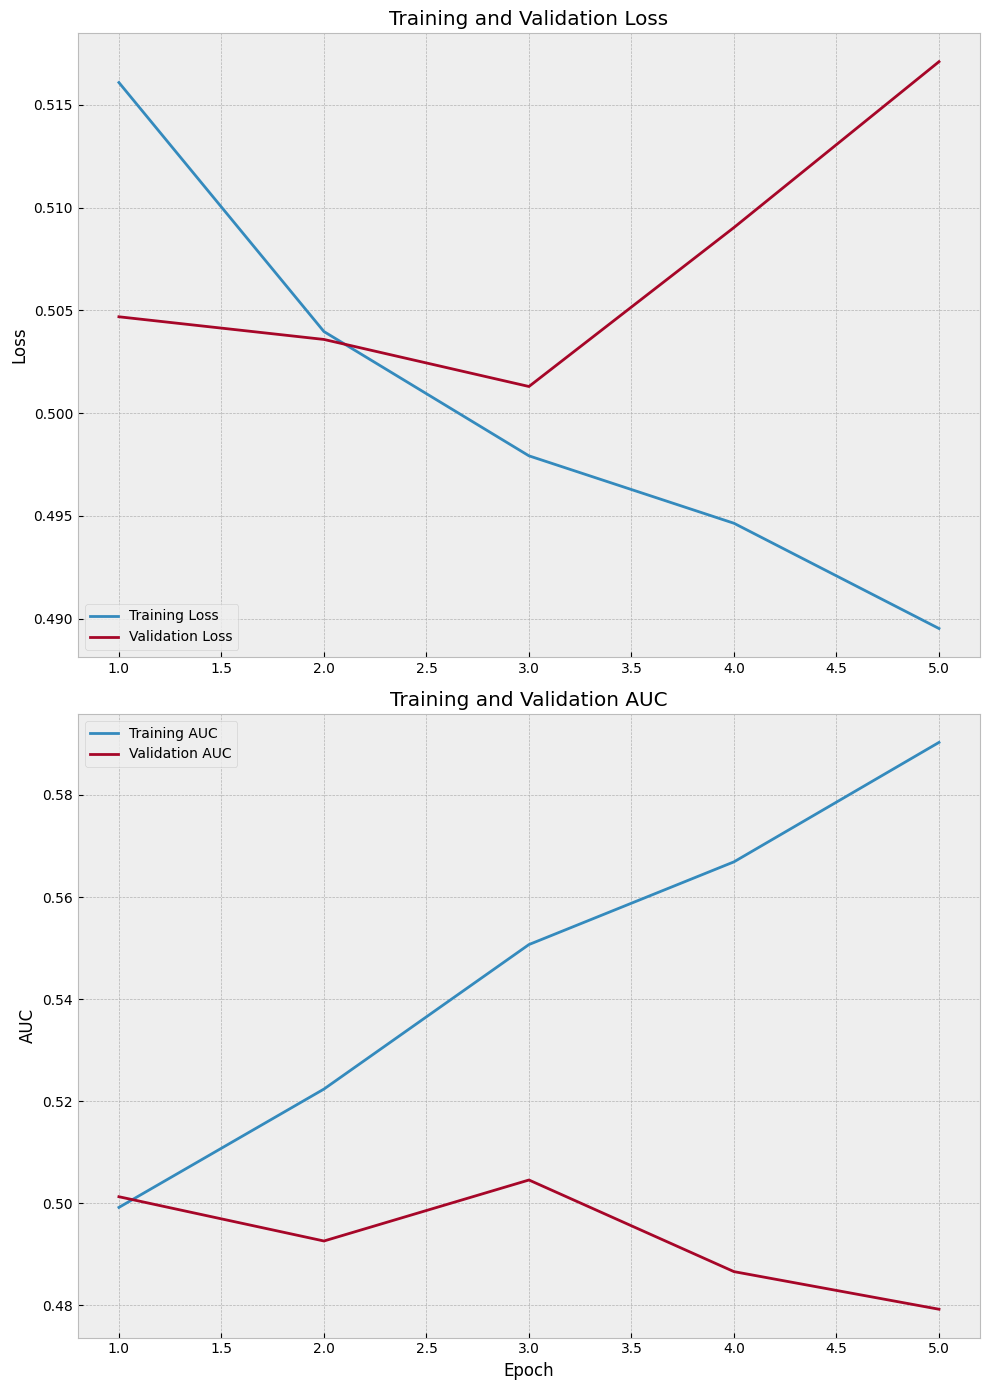

In [ ]:
compare_learning_curves(history_nomask, history_mask, labels=("No Mask", "With Mask"))

Fungsi Evaluasi Confusion Matrix

In [ ]:
def evaluate_confusion_matrices(model, valid_df, class_names, base_gen, IMG_SIZE, batch_size=16, thresh=0.1):
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math
    
    # Non shuffled generator for evaluation
    valid_eval_gen = base_gen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col='path',
        y_col=class_names,
        class_mode='raw',
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=batch_size
    )

    # Predict
    preds = model.predict(valid_eval_gen, verbose=0)
    y_true = valid_df[class_names].to_numpy()
    y_pred = (preds >= thresh).astype(int)

    # Classification report
    print("Classification report (per-class):")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=class_names, 
        zero_division=0
    ))

    print("Macro F1 (sklearn):", f1_score(y_true, y_pred, average='macro'))
    print("Micro F1 (sklearn):", f1_score(y_true, y_pred, average='micro'))

    # Confusion matrices per class
    n = len(class_names)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()

    for i, cls in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        sns.heatmap(
            cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
            ax=axes[i]
        )
        axes[i].set_title(f"{cls} (Thresh={thresh})")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    # Hide unused subplot slots
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.29      1.00      0.45        67
    Cardiomegaly       0.17      0.95      0.28        38
   Consolidation       0.16      0.38      0.23        13
           Edema       0.24      1.00      0.38        55
Pleural_Effusion       0.34      1.00      0.50        79

       micro avg       0.25      0.96      0.40       252
       macro avg       0.24      0.87      0.37       252
    weighted avg       0.27      0.96      0.41       252
     samples avg       0.25      0.68      0.35       252

Macro F1 (sklearn): 0.36782412423276634
Micro F1 (sklearn): 0.4023275145469659


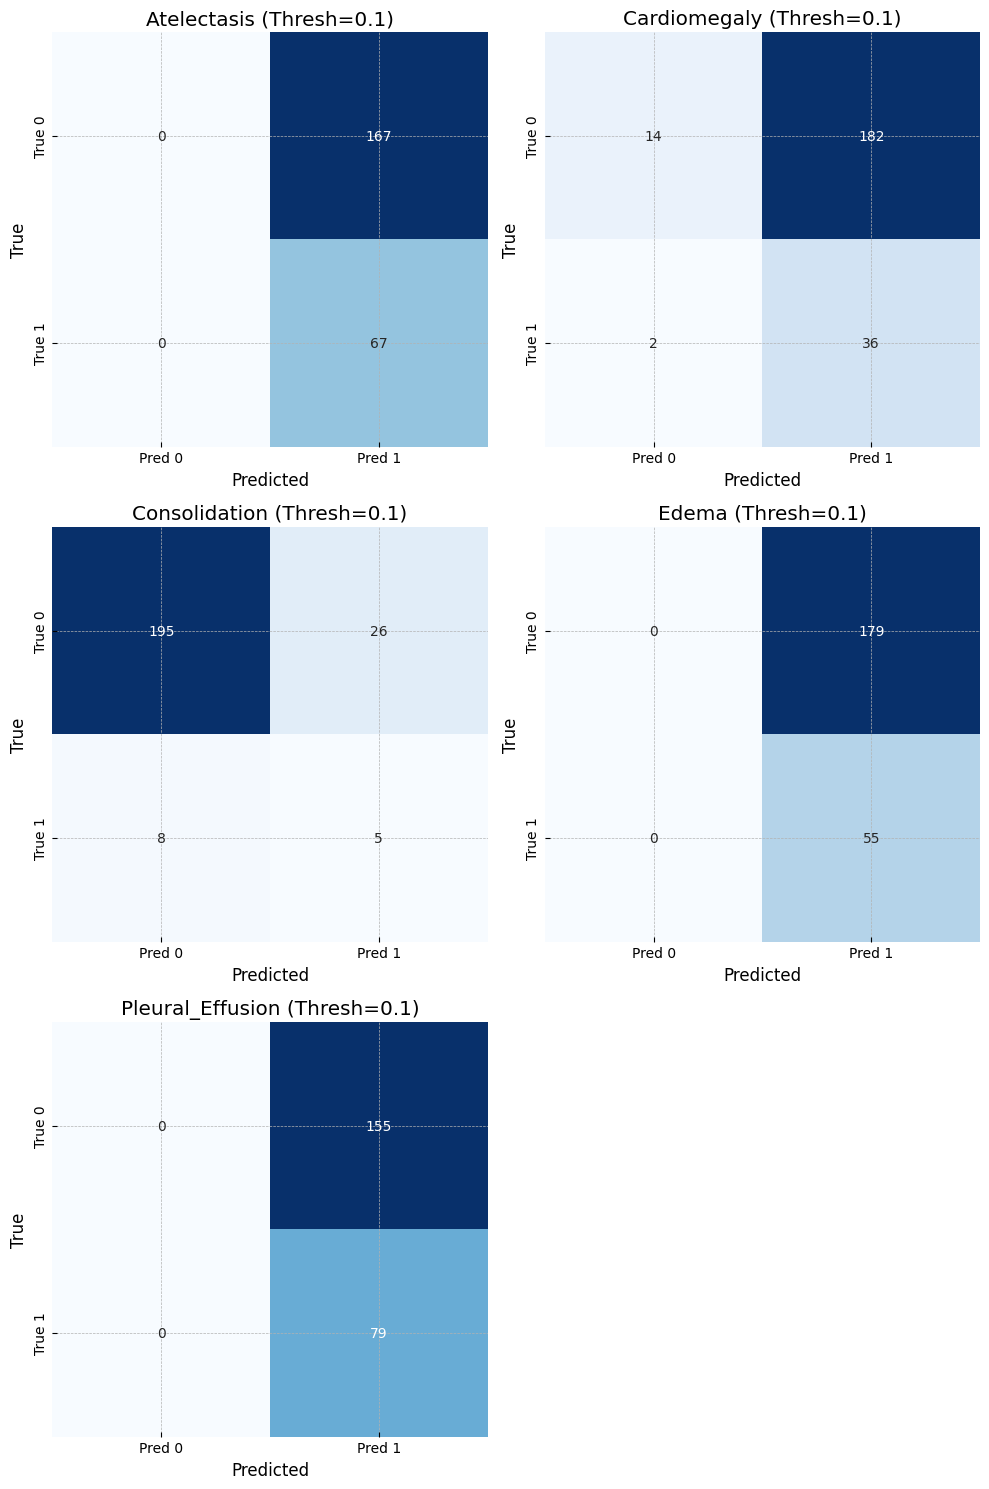

In [ ]:
evaluate_confusion_matrices(model, valid_df, class_names, base_gen, IMG_SIZE)

Fungsi Penghitung AUC Validasi

In [ ]:
def evaluate_auc_two_models(
    model1, model2,
    valid_df, class_names,
    base_gen, IMG_SIZE,
    labels=("Model 1", "Model 2")
):
    import math
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_auc_score, roc_curve

    BATCH_SIZE = 16

    valid_eval_gen = base_gen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col="path",
        y_col=class_names,
        class_mode="raw",
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=BATCH_SIZE
    )

    # Predictions
    preds1 = model1.predict(valid_eval_gen, verbose=1)
    preds2 = model2.predict(valid_eval_gen, verbose=1)

    y_true = valid_df[class_names].to_numpy()

    # AUC per class
    auc1 = {}
    auc2 = {}

    for i, cls in enumerate(class_names):
        try:
            auc1[cls] = roc_auc_score(y_true[:, i], preds1[:, i])
        except ValueError:
            auc1[cls] = np.nan
        try:
            auc2[cls] = roc_auc_score(y_true[:, i], preds2[:, i])
        except ValueError:
            auc2[cls] = np.nan

    # Display table
    df1 = pd.DataFrame.from_dict(auc1, orient="index", columns=[f"{labels[0]} AUC"])
    df2 = pd.DataFrame.from_dict(auc2, orient="index", columns=[f"{labels[1]} AUC"])

    comparison_df = pd.concat([df1, df2], axis=1)

    print("\n=== AUC per class comparison ===\n")
    print(comparison_df)

    # Macro and micro AUC
    try:
        macro1 = roc_auc_score(y_true, preds1, average="macro")
    except ValueError:
        macro1 = np.nan

    try:
        micro1 = roc_auc_score(y_true, preds1, average="micro")
    except ValueError:
        micro1 = np.nan

    try:
        macro2 = roc_auc_score(y_true, preds2, average="macro")
    except ValueError:
        macro2 = np.nan

    try:
        micro2 = roc_auc_score(y_true, preds2, average="micro")
    except ValueError:
        micro2 = np.nan

    print("\nMacro AUC:")
    print(f"{labels[0]}: {macro1}")
    print(f"{labels[1]}: {macro2}")

    print("\nMicro AUC:")
    print(f"{labels[0]}: {micro1}")
    print(f"{labels[1]}: {micro2}")

    # ROC curves side by side
    rows = len(class_names)
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))

    for i, cls in enumerate(class_names):
        # Model 1 plot
        ax1 = axes[i][0]
        try:
            fpr1, tpr1, _ = roc_curve(y_true[:, i], preds1[:, i])
            ax1.plot(fpr1, tpr1, label=f"AUC={auc1[cls]:.3f}")
            ax1.plot([0,1], [0,1], "k--")
            ax1.set_title(f"{cls} - {labels[0]}")
            ax1.set_xlabel("False Positive Rate")
            ax1.set_ylabel("True Positive Rate")
            ax1.legend()
        except ValueError:
            ax1.set_title(f"{cls} - no positives")
            ax1.axis("off")

        # Model 2 plot
        ax2 = axes[i][1]
        try:
            fpr2, tpr2, _ = roc_curve(y_true[:, i], preds2[:, i])
            ax2.plot(fpr2, tpr2, label=f"AUC={auc2[cls]:.3f}")
            ax2.plot([0,1], [0,1], "k--")
            ax2.set_title(f"{cls} - {labels[1]}")
            ax2.set_xlabel("False Positive Rate")
            ax2.set_ylabel("True Positive Rate")
            ax2.legend()
        except ValueError:
            ax2.set_title(f"{cls} - no positives")
            ax2.axis("off")

    plt.tight_layout()
    plt.show()


Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step

AUC per class:
Atelectasis: 0.5709
Cardiomegaly: 0.5442
Consolidation: 0.5538
Edema: 0.3961
Pleural_Effusion: 0.4609

Macro AUC: 0.5051860673226655
Micro AUC: 0.6455631635370198


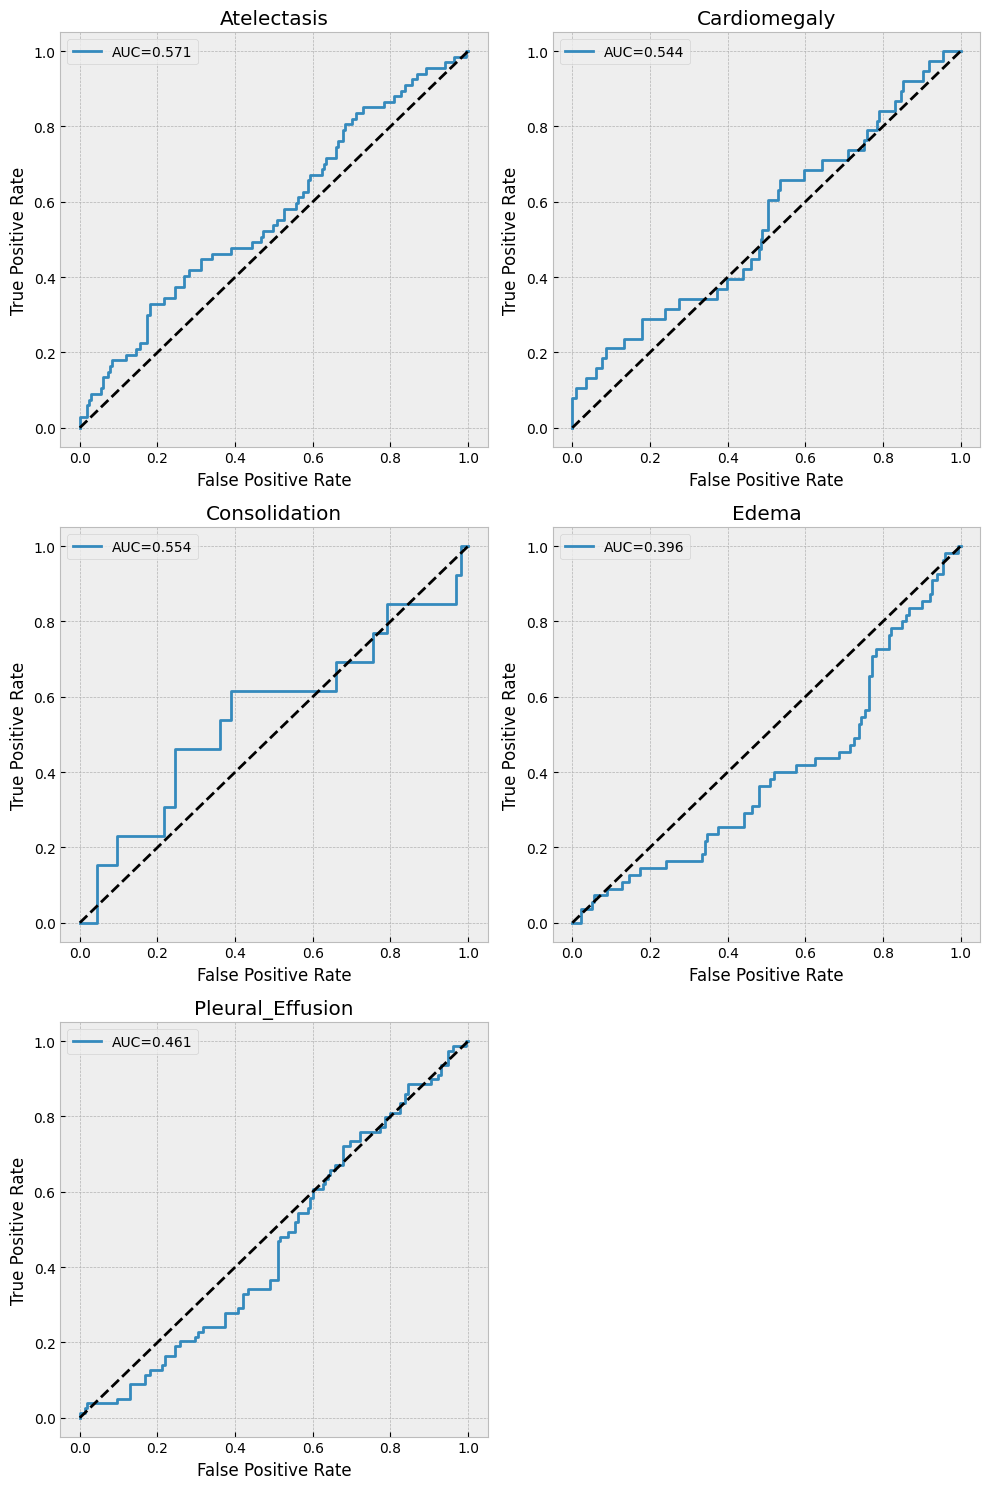

In [ ]:
evaluate_auc_two_models(
    model, model_mask,
    valid_df, class_names,
    base_gen, IMG_SIZE,
    labels=("No Mask", "With Mask")
)

In [ ]:
# Store the trained model in MongoDB using GridFS
uploaded_model = gridfs.GridFS(db)
model_path = "densenet121_chexpert.keras"

with open(model_path, "rb") as f:
    file_id = uploaded_model.put(f, filename=model_path.split("/")[-1])
    print("Uploaded with ID:", file_id)